<a href="https://colab.research.google.com/github/porter7678/image_caption_generator/blob/master/image_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install torch 
# !pip install torchvision
# !pip install tqdm
# !pip install kaggle

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
import os

assert torch.cuda.is_available()

In [0]:
os.environ['KAGGLE_USERNAME'] = 'porter7678'
if not 'KAGGLE_KEY' in os.environ:
  os.environ['KAGGLE_KEY'] = input()

In [4]:
# ~60 secs
!kaggle datasets download -d ming666/flicker8k-dataset
!unzip -q flicker8k-dataset.zip

# Discard extra directories
! rm -rf flickr8k_dataset/
! rm -rf flickr8k_text/
! rm -rf sample_data/

# Create Train and Valid directories
os.mkdir('Flickr8k_Dataset/Train_Images')
os.mkdir('Flickr8k_Dataset/Valid_Images')
os.mkdir('Flickr8k_Dataset/Valid_Images/Flicker8k_Dataset_Valid')
os.replace('Flickr8k_Dataset/Flicker8k_Dataset', 'Flickr8k_Dataset/Train_Images/Flicker8k_Dataset_Train')

 99% 2.06G/2.08G [00:31<00:00, 80.8MB/s]
100% 2.08G/2.08G [00:31<00:00, 70.0MB/s]


In [0]:
os.replace()

In [169]:
############ - DATATSET README - ################################################################
# Flickr8k.token.txt - the raw captions of the Flickr8k Dataset,
#       the first column is the ID of the caption which is "image address # caption number"
# Flickr8k.lemma.txt - the lemmatized version of the above captions 
# Flickr_8k.trainImages.txt - The list of training images used in our experiments
# Flickr_8k.devImages.txt - The list of development/validation images used in our experiments
# Flickr_8k.testImages.txt - The list of test images used in our experiments
#################################################################################################
# 8091 images

# with open('Flickr8k_text/Flickr_8k.testImages.txt', 'r') as f:
#     lines = f.readlines()

# print(len(lines))

1000


In [0]:
def show_imgs(x, new_fig=True):
    '''
    Arguments:
        x ((c,m,n) tensor): The image to be shown
    '''
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

In [192]:
# This was all working great in case stuff below breaks everything

root = 'Flickr8k_Dataset/Flicker8k_Dataset_train'

# NOTE: Really unsure about this sizing
img_size = 128

image_dataset = datasets.ImageFolder(root=root,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               #transforms.CenterCrop(img_size),  # This is the line that is making images square
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

RuntimeError: ignored

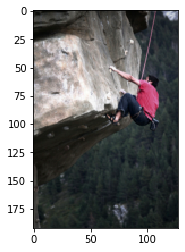

In [191]:
num = 8090

ix = num
x, _ = image_dataset[ix]
show_imgs(x)

In [135]:
class ImageCaptionDataset(Dataset):
    def __init__(self, root, train=True):

        img_size = 128

        self.image_folder = datasets.ImageFolder(root=root,
                                                transform=transforms.Compose([
                                                    transforms.Resize(img_size),
                                                    #transforms.CenterCrop(img_size),  # This is the line that is making images square
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                                ]))
        
        self.caption_folder = None

    
    def __getitem__(self):
        pass

    def __len__(self):
        return 49


<class 'torchvision.datasets.folder.ImageFolder'>


In [0]:
valid_img_names = []

file_names = ['Flickr8k_text/Flickr_8k.devImages.txt', 'Flickr8k_text/Flickr_8k.testImages.txt']

for file_name in file_names:
    with open(file_name, 'r') as f:
        for line in f.readlines():
            valid_img_names.append(line.strip())


In [162]:
print(valid_img_names)

['2090545563_a4e66ec76b.jpg', '3393035454_2d2370ffd4.jpg', '3695064885_a6922f06b2.jpg', '1679557684_50a206e4a9.jpg', '3582685410_05315a15b8.jpg', '1579798212_d30844b4c5.jpg', '269650644_059a84ece5.jpg', '2596619849_7b635dd310.jpg', '2635164923_2a774f7854.jpg', '3583321426_f373c52161.jpg', '2735792721_b8fe85e803.jpg', '3484841598_e26ee96aab.jpg', '2490687446_9d46fdf5a9.jpg', '2987328689_96a2d814f1.jpg', '2992614450_b5a6692239.jpg', '2391812384_7429b5e567.jpg', '3665179773_dd217416fc.jpg', '3515904775_f8acc5909e.jpg', '3616808182_fb4eaec778.jpg', '3652150541_8fb5a3a5d1.jpg', '3693961165_9d6c333d5b.jpg', '2895700779_fac1d9d278.jpg', '2474092890_6c0781a8ed.jpg', '3420469425_2980b4cd30.jpg', '537222436_ab406234ce.jpg', '3419634480_c390f62a6e.jpg', '2659183350_730951f740.jpg', '1178705300_c224d9a4f1.jpg', '989851184_9ef368e520.jpg', '535123126_c06c1ab9bf.jpg', '3226541300_6c81711e8e.jpg', '3457784061_8f77f43a9c.jpg', '3364715316_df8c20bac1.jpg', '233361142_d9d5f0cae9.jpg', '634891010_9fa189e

In [0]:
for file_name in valid_img_names:
    os.replace('Flickr8k_Dataset/Train_Images/Flicker8k_Dataset_Train/' + file_name, 'Flickr8k_Dataset/Valid_Images/Flicker8k_Dataset_Valid/' + file_name)

In [166]:
# print(len(os.listdir('Flickr8k_Dataset/Flicker8k_Dataset_valid/')))
# print(len(os.listdir('Flickr8k_Dataset/Flicker8k_Dataset_train/')))

2000
6091
